## Redes neuronales II. PyTorch
___

#### Ejercicio 2.a
---

Crea un modelo para la predicción de la calidad del vino ("vinho verde" _dataset_).

OPCIÓN A) La puntuación de calidad (_target_) se trata como un valor **continuo**

##### GLOBALS
---

In [88]:
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
import csv
import numpy as np

NORM = True
GPU = True

##### LOADING DATA
---

In [67]:
# --> Load data, skip row of column names
wine_path = 'data/winequality-white.csv'
wineq_np = np.loadtxt(wine_path, dtype=np.float32, delimiter=";", skiprows=1)
wineq = torch.from_numpy(wineq_np)

# --> Print dataset info
column_list = next(csv.reader(open(wine_path), delimiter=';'))
print("-"*80)
print(f"DATASET: {wineq.shape}")
print("COLUMNS:")
print(column_list)
print("DATA:")
print(wineq)

# Samples and target data
t_samples = wineq[:, :-1]
t_target = wineq[:, -1].unsqueeze(1)

# samples, features
M,N = t_samples.shape

# --> splitting
print("-"*80)
n_samples = wineq.shape[0]
n_val = int(0.2 * n_samples)

# create indices
shuffled_indices = torch.randperm(n_samples)
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

# training dataset
t_samples_train = t_samples[train_indices]
t_target_train = t_target[train_indices]
print(f"TRAINING DATASET: samples: {t_samples_train.shape} target: {t_target_train.shape}")

# validation dataset
t_samples_val = t_samples[val_indices]
t_target_val = t_target[val_indices]
print(f"VALIDATION DATASET: samples: {t_samples_val.shape} target: {t_target_val.shape}")

# move to GPU
if GPU:
    t_samples_train = t_samples_train.cuda()
    t_target_train = t_target_train.cuda()
    t_samples_val = t_samples_val.cuda()
    t_target_val = t_target_val.cuda()

# normalización (si es necesaria). Importante: indicar dimensión en mean() y std()
if NORM:
    t_samples_train_n = (t_samples_train - t_samples_train.mean(dim=0))/t_samples_train.std(dim=0)
    t_samples_val_n = (t_samples_val - t_samples_val.mean(dim=0))/t_samples_val.std(dim=0)
else:
    t_samples_train_n = t_samples_train
    t_samples_val_n = t_samples_val

--------------------------------------------------------------------------------
DATASET: torch.Size([4898, 12])
COLUMNS:
['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']
DATA:
tensor([[ 7.0000,  0.2700,  0.3600,  ...,  0.4500,  8.8000,  6.0000],
        [ 6.3000,  0.3000,  0.3400,  ...,  0.4900,  9.5000,  6.0000],
        [ 8.1000,  0.2800,  0.4000,  ...,  0.4400, 10.1000,  6.0000],
        ...,
        [ 6.5000,  0.2400,  0.1900,  ...,  0.4600,  9.4000,  6.0000],
        [ 5.5000,  0.2900,  0.3000,  ...,  0.3800, 12.8000,  7.0000],
        [ 6.0000,  0.2100,  0.3800,  ...,  0.3200, 11.8000,  6.0000]])
--------------------------------------------------------------------------------
TRAINING DATASET: samples: torch.Size([3919, 11]) target: torch.Size([3919, 1])
VALIDATION DATASET: samples: torch.Size([979, 11]) target: torch.Size([979, 1])


##### MODELO
---

In [132]:
seq_model = nn.Sequential(
            nn.Linear(N, 24),
            nn.Tanh(),
            nn.Linear(24, 12),
            nn.Tanh(),
            nn.Linear(12, 1))
if GPU:
    seq_model.cuda()
seq_model

Sequential(
  (0): Linear(in_features=11, out_features=24, bias=True)
  (1): Tanh()
  (2): Linear(in_features=24, out_features=12, bias=True)
  (3): Tanh()
  (4): Linear(in_features=12, out_features=1, bias=True)
)

##### TRAINING LOOP
---

In [90]:
def training_loop(n_epochs, optimizer, model, loss_fn, 
                  t_samples_train, t_samples_val, t_target_train, t_target_val, 
                  output=True):
    t_loss = torch.zeros([n_epochs+1, 2])
    for epoch in range(1, n_epochs+1):
        t_predict_train = model(t_samples_train) # usamos el modelo suministrado
        loss_train = loss_fn(t_predict_train, t_target_train)  # calcula el error 
        
        optimizer.zero_grad()  # inicializa los gradientes
        loss_train.backward()        # calcula los gradientes
        optimizer.step()       # actualiza los parámetros
        
        # validación
        with torch.no_grad():
            t_predict_val = model(t_samples_val) 
            loss_val = loss_fn(t_predict_val, t_target_val)  
            
        t_loss[epoch] = torch.tensor([loss_train, loss_val])
        
        if output and (epoch==1 or epoch%250==0):
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                    f" Validation loss {loss_val.item():.4f}")
    return t_loss

##### TRAINING THE MODEL
---

In [133]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)
t_loss = training_loop(
    n_epochs=2000,
    optimizer=optimizer,
    model=seq_model,       # <-- ANN model
    loss_fn=nn.MSELoss(),
    t_samples_train=t_samples_train_n,
    t_samples_val=t_samples_val_n,
    t_target_train=t_target_train,
    t_target_val=t_target_val)

Epoch 1, Training loss 35.9178, Validation loss 35.1990
Epoch 250, Training loss 1.0323, Validation loss 0.9172
Epoch 500, Training loss 0.6362, Validation loss 0.5722
Epoch 750, Training loss 0.6126, Validation loss 0.5521
Epoch 1000, Training loss 0.5994, Validation loss 0.5418
Epoch 1250, Training loss 0.5911, Validation loss 0.5358
Epoch 1500, Training loss 0.5854, Validation loss 0.5320
Epoch 1750, Training loss 0.5813, Validation loss 0.5294
Epoch 2000, Training loss 0.5781, Validation loss 0.5274


##### PLOTTING ERROR
---

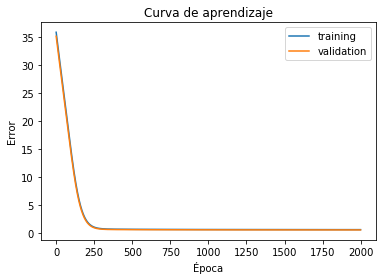

In [134]:
from matplotlib import pyplot as plt

t_x = torch.arange(t_loss.size()[0])
plt.plot(t_loss[1:,0].detach().numpy(), label = 'training') # detach().numpy() porque tiene gradientes
plt.plot(t_loss[1:,1], label = 'validation') # no tiene gradientes. No necesitamos convertirlo
plt.title(f"Curva de aprendizaje")
plt.ylabel("Error")
plt.xlabel("Época")
plt.legend()
plt.show()

##### PLOTTING MODEL & PREDICTION
---

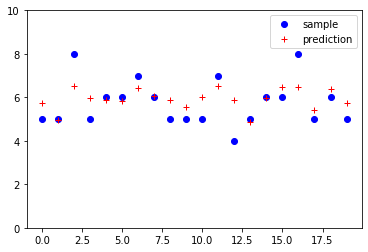

In [135]:
# Take NS random samples from validation set
NS = 20
indices = torch.randperm(t_samples_val_n.shape[0])[-NS:]
t_samples = t_samples_val_n[indices]
#t_predict = torch.round(seq_model(t_samples))
t_predict = seq_model(t_samples)
t_target = t_target_val[indices]
plt.plot(t_target.cpu(), "bo", label='sample')
plt.plot(t_predict.cpu().detach().numpy(), "r+", label='prediction')
plt.ylim([0, 10])
plt.legend()
plt.show()